In [ ]:
# %%px
use_dolfinx = True
nprocs = 4

### colab

In [ ]:
# %%px
import os
colab = os.getcwd() == "/content"


In [ ]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# drive.flush_and_unmount()  # Smonta Google Drive
# drive.mount('/content/drive', force_remount=True)  # Rimonta


In [ ]:
# %%px
if colab:
    if use_dolfinx:
        try:
            import dolfinx
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
            import dolfinx
        try:
            import gmsh
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
            import gmsh

### parallel

In [ ]:
## Parallel programming imports
import ipyparallel as ipp
from mpi4py import MPI

In [ ]:
os.environ["OMPI_ALLOW_RUN_AS_ROOT"] = "1"
os.environ["OMPI_ALLOW_RUN_AS_ROOT_CONFIRM"] = "1"
os.environ["OMP_NUM_THREADS"] = "24"     # un rank su 48 core (un socket)
os.environ["MKL_NUM_THREADS"] = "24"     # se usi MKL per algebra lineare

cluster = ipp.Cluster(
    engines="mpi",
    n=nprocs,
    engine_launcher_args={
        "mpirun_args": [
            "--allow-run-as-root",         # già confermato con variabili ma non guasta
            # "--use-hwthread-cpus"          # 1: conta gli hw threads come slot
            "--bind-to", "socket",
            "--map-by", "socket",
            "--report-bindings"
            # oppure: "--map-by", ":OVERSUBSCRIBE"
        ]
    }
)
rc = cluster.start_and_connect_sync()
print("Engine MPI avviati correttamente!")


Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

Engine MPI avviati correttamente!


### dolfinx

In [ ]:
%%px
use_dolfinx = True

In [ ]:
%%px
import os
colab = os.getcwd() == "/content"

In [ ]:
%%px
if colab:
    if use_dolfinx:
        try:
            import dolfinx
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
            import dolfinx
        try:
            import gmsh
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
            import gmsh

### import

In [ ]:
%%px
from __future__ import print_function


In [ ]:
!pip install pyDOE

In [ ]:
%%px
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import copy
import tqdm.autonotebook
if colab:
    if use_dolfinx:
        import gmsh
        from mpi4py import MPI
        from petsc4py import PETSc

        from basix.ufl import element

        from dolfinx.fem import (
            Constant,
            Function,
            functionspace,
            assemble_scalar,
            dirichletbc,
            form,
            locate_dofs_topological,
            locate_dofs_topological,
            set_bc,
        )
        from dolfinx.fem.petsc import (
            apply_lifting,
            assemble_matrix,
            assemble_vector,
            create_vector,
            create_matrix,
            set_bc,
        )
        from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
        from dolfinx.io import VTXWriter, gmshio
        from ufl import (
            FacetNormal,
            Measure,
            TestFunction,
            TrialFunction,
            as_vector,
            div,
            dot,
            dx,
            inner,
            lhs,
            grad,
            nabla_grad,
            rhs,
        )

        gmsh.initialize()
import pyDOE

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stderr:3] WARNING:py.warnings:/tmp/ipykernel_13490/1710578147.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook



[stderr:2] WARNING:py.warnings:/tmp/ipykernel_13489/1710578147.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook



[stderr:0] WARNING:py.warnings:/tmp/ipykernel_13486/1710578147.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook



[stderr:1] WARNING:py.warnings:/tmp/ipykernel_13488/1710578147.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook



In [ ]:
%%px
from IPython.display import clear_output as clc

plt.style.use("default")


In [ ]:
%%px
if colab:
    if use_dolfinx:
        import ufl
        from basix.ufl import element, mixed_element
        from dolfinx import fem, la
        from dolfinx.fem import (Constant, Function, dirichletbc,
                                extract_function_spaces, form, functionspace,
                                locate_dofs_topological)
        from dolfinx.fem.petsc import assemble_matrix_block, assemble_vector_block
        from dolfinx.io import XDMFFile
        from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
        from ufl import div, dx, grad, inner
        from ufl import CellDiameter, sqrt, FacetArea

In [ ]:
%%px
from scipy.interpolate import RBFInterpolator

In [ ]:
%%px
plt.style.use("default")
%config InlineBackend.figure_format = 'retina'

In [ ]:
%%px
def add_zoom(zoom = 1.5, dpi = 100):
    plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom)
    plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom)
    plt.gcf().dpi = dpi

In [ ]:
%%px
def scatter_array(arr, label = "label", leg = False, zoom = 1, dpi = 100, s = 1, c = None):
    if not c==None:
        plt.scatter(arr[:, 0], arr[:, 1], label = label, s = s, c = c)
    else:
        plt.scatter(arr[:, 0], arr[:, 1], label = label, s = s)
    # plt.scatter(new_control_points_coords[:, 0], new_control_points_coords[:, 1], c = "b", label = "new control pts")

    add_zoom(zoom, dpi = dpi)
    plt.gca().set_aspect("equal")
    plt.gca().set_adjustable("box")

    if leg:
        plt.gca().legend(loc = "upper right")
    # plt.show()

In [ ]:
%%px
if colab:
    os.chdir("/content/drive/MyDrive/mySHRED")

# Parameters

In [ ]:
%%px

L = 20
H = 20
x_le, y_le = 0.25 * L, 0.5 * H

R = 0.5
l = 3*R
centers = [[0.25*L, H/2],
           [0.25*L + l*(np.sqrt(3)/2), H/2 + l/2],
           [0.25*L + l*(np.sqrt(3)/2), H/2 - l/2]]


# Utilities

###mesh utilities

In [ ]:
%%px
def get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = 10.0, y1 = 4.0, each = 2, step_size = 0.05, mesh_type="rectangle"):

    assert(len(airfoil_coords)==len(new_airfoil_coords))

    N_points = airfoil_coords.shape[0]
    airfoil_control_points_ids = np.arange(0, N_points, each).tolist()
    airfoil_control_points = airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])
    new_airfoil_control_points = new_airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])

    airfoil_displacements = np.array(new_airfoil_control_points - airfoil_control_points)

    if mesh_type=="rectangle":
        wall1_points = np.concatenate((np.arange(x0, x1, step_size).reshape(-1,1), np.zeros(round(x1/step_size)).reshape(-1,1)), axis = 1)
        wall2_points = np.concatenate((x1 * np.ones(round(y1/step_size)).reshape(-1,1), np.arange(y0, y1, step_size).reshape(-1,1)), axis = 1)
        wall3_points = np.concatenate((np.arange(x1, x0, -step_size).reshape(-1,1), y1 * np.ones(round(x1/step_size)).reshape(-1,1)), axis = 1)
        wall4_points = np.concatenate((np.zeros(round(y1/step_size)).reshape(-1,1), np.arange(y1, y0, -step_size).reshape(-1,1)), axis = 1)

        control_points = np.concatenate((airfoil_control_points, wall1_points, wall2_points, wall3_points, wall4_points), axis = 0)
        displacements = np.concatenate((airfoil_displacements, np.zeros((wall1_points.shape[0] + wall2_points.shape[0] + wall3_points.shape[0] + wall4_points.shape[0], 2))), axis = 0)
    elif mesh_type=="circle":
        theta = np.arange(0, 2*np.pi, step_size)
        farfield_points = R * np.concatenate((np.cos(theta).reshape(-1, 1), np.sin(theta).reshape(-1, 1)), 1)

        control_points = np.concatenate((airfoil_control_points, farfield_points), axis = 0)
        displacements = np.concatenate((airfoil_displacements, np.zeros(farfield_points)), axis = 0)

    elif mesh_type=="cmesh":
        theta = np.arange(0, 2*np.pi, step_size)
        farfield_points = R * np.concatenate((np.cos(theta).reshape(-1, 1), np.sin(theta).reshape(-1, 1)), 1)

        control_points = np.concatenate((airfoil_control_points, farfield_points), axis = 0)
        displacements = np.concatenate((airfoil_displacements, np.zeros(farfield_points)), axis = 0)

    return control_points, displacements



In [ ]:
%%px
def get_global_coords(mesh):

    if MPI.COMM_WORLD.size==1:
        return mesh.geometry.x

    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    Q_vec = functionspace(mesh, s_cg1)

    im = Q_vec.dofmap.index_map
    N = im.size_global

    # Alloco un array di coordinate (N, 2) su rank 0
    coords_global = np.zeros((N, 3))

    # Su ogni rank preparo
    coords_local = Q_vec.tabulate_dof_coordinates()     # (size_local, 2)
    local_idxs   = np.arange(im.size_local, dtype=int)
    owned        = np.setdiff1d(local_idxs, im.ghosts)
    global_idxs  = im.local_to_global(owned)           # lunghezza = n_owned
    coords_owned = coords_local[owned]

    # Gather di (coords_owned, global_idxs) su rank 0
    gathered_coords = comm.gather(coords_owned,   root=0)
    gathered_globs  = comm.gather(global_idxs,    root=0)

    if rank==0:
        # Riempi il coords_global usando i global indices
        for pts, gl in zip(gathered_coords, gathered_globs):
            coords_global[gl, :] = pts

        return coords_global
    else:
        return None

    # np.savez("data/pinball_data.npz", naca0012_airfoil_coords = pinball_coords, naca0012_coords = coords_global)

In [ ]:
%%px
def get_boundary_idxs(mesh, ft, marker):
    boundary_facets = dolfinx.mesh.exterior_facet_indices(mesh.topology)
    vertices = dolfinx.mesh.compute_incident_entities(mesh.topology, ft.find(marker), mesh.topology.dim-1, 0)
    idxs = dolfinx.cpp.mesh.entities_to_geometry(mesh._cpp_object, 0, vertices, False)

    return idxs[:, 0].tolist()

In [ ]:
%%px
def get_control_points_and_displacements2(mesh, ft, new_obstacle_coords, obstacle_marker, boundary_markers: list, obstacle_coords=None, each=4):

    if obstacle_coords is None:
        obstacle_indices = get_boundary_idxs(mesh, ft, obstacle_marker)
        obstacle_coords = order_polygon(mesh.geometry.x[obstacle_indices])[:, :2]
    else:
        obstacle_coords = order_polygon(obstacle_coords)
    new_obstacle_coords = order_polygon(new_obstacle_coords)

    boundary_indices = []
    for marker in boundary_markers:
        boundary_indices += get_boundary_idxs(mesh, ft, marker)
    boundary_indices = np.array(boundary_indices)
    boundary_coords = order_polygon(mesh.geometry.x[boundary_indices])[:, :2]

    assert(len(obstacle_coords)==len(new_obstacle_coords))

    # Control points
    obstacle_control_points = obstacle_coords[::each] # + np.array([x_le, y_le])
    new_obstacle_control_points = new_obstacle_coords[::each] # + np.array([x_le, y_le])
    boundary_control_points = boundary_coords[::each]
    control_points = np.concatenate((obstacle_control_points, boundary_control_points), axis = 0)

    # Displacements
    obstacle_displacements = np.array(new_obstacle_control_points - obstacle_control_points)
    boundary_displacements = np.zeros_like(boundary_control_points)
    displacements = np.concatenate((obstacle_displacements, boundary_displacements), axis = 0)

    return control_points, displacements

In [ ]:
%%px
def interpolate_coords(coords, control_points, displacements):
    rbf = RBFInterpolator(control_points, displacements, neighbors=None, smoothing=0.0, epsilon=None, degree=None)
    displacements = rbf(coords[:, :2])
    new_coords = coords[:, :2] + displacements
    return new_coords

In [ ]:
%%px
def smooth_mesh(mesh, iterations=10, omega=0.3, fix_boundary=True):
    """
    Applica Laplacian smoothing alla mesh DolfinX in-place.

    Parametri:
        mesh         : dolfinx.mesh.Mesh
        iterations   : numero di passi di smoothing
        omega        : fattore di rilassamento (0<omega<1)
        fix_boundary : se True, i nodi su facce esterne non vengono mossi
    """
    # Copia delle coordinate
    coords = mesh.geometry.x.copy()

    # Topologia necessaria
    topo = mesh.topology
    topo.create_connectivity(0, topo.dim)
    topo.create_connectivity(topo.dim, 0)

    # Connessioni vertice->cella e cella->vertice
    v2c = topo.connectivity(0, topo.dim)
    c2v = topo.connectivity(topo.dim, 0)

    # Calcola facce di bordo e vertici di bordo
    boundary_vertices = set()
    if fix_boundary:
        # Crea connettività faccia->vertice
        topo.create_connectivity(topo.dim - 1, 0)
        # Indici delle facet esterne
        boundary_facets = dolfinx.mesh.exterior_facet_indices(topo)
        # Vertici incidenti a queste facet
        bv = dolfinx.mesh.compute_incident_entities(topo, boundary_facets, topo.dim - 1, 0)
        # Mappa C++ -> geometria (necessario per assicurare ordinamento corretto)
        vertex_to_geometry = dolfinx.cpp.mesh.entities_to_geometry(mesh._cpp_object, 0, bv, False)
        boundary_vertices = set(bv)

    # Loop di smoothing
    for _ in range(iterations):
        print(f"Smoothing iter n°{_+1}")
        new_coords = coords.copy()
        for vid in range(coords.shape[0]):
            if vid in boundary_vertices:
                continue
            # celle attorno al vertice
            cell_ids = v2c.links(vid)
            # insieme vertici vicini
            neigh_vs = set()
            for cid in cell_ids:
                neigh_vs.update(c2v.links(cid))
            neigh_vs.discard(vid)
            if not neigh_vs:
                continue
            # baricentro
            centroid = coords[list(neigh_vs)].mean(axis=0)
            # spostamento
            new_coords[vid] += omega * (centroid - coords[vid])
        coords = new_coords

    # Scrivi nuove coordinate
    mesh.geometry.x[:] = coords
    return mesh

In [ ]:
%%px
def interpolate_mesh(mesh, control_points, displacements,
                           smooth=False, smooth_iters=15, smooth_omega=0.3):
    # 1) Interpolazione RBF
    from dolfinx.fem import FunctionSpace
    import ufl

    # usa Lagrange di grado 1
    V = functionspace(mesh, element("Lagrange", mesh.topology.cell_name(), 1))
    coords = V.tabulate_dof_coordinates()  # array N x gdim

    # RBF
    rbf = RBFInterpolator(control_points, displacements, neighbors=None, smoothing=0.0)
    disp = rbf(coords[:, :2])
    mesh.geometry.x[:, :2] = coords[:, :2] + disp

    # 2) smoothing Laplaciano
    if smooth:
        mesh = smooth_mesh(mesh,
                          iterations=smooth_iters,
                          omega=smooth_omega,
                          fix_boundary=True)
    return mesh

In [ ]:
%%px
def order_polygon(xy_points):
    """
    Orders a set of unordered polygon points into a counterclockwise sequence.
    """
    xy_points = np.array(xy_points, dtype=np.float32)

    # Compute the centroid (average of all points)
    centroid = np.mean(xy_points, axis=0)

    # Compute angles relative to centroid
    angles = np.arctan2(xy_points[:, 1] - centroid[1], xy_points[:, 0] - centroid[0])

    # Sort points by angle in counterclockwise order
    sorted_indices = np.argsort(angles)
    ordered_points = xy_points[sorted_indices]

    return ordered_points

### dolfinx utilities

#### bcs

In [ ]:
%%px
class InletVelocity:
    def __init__(self, U_max, alpha):
        # self.t = t
        self.U_max = U_max
        self.alpha = alpha

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = (
            self.U_max
        )
        values[1] = (
            0
        )
        return values

def get_bcs(mesh, V, Q, ft, U_max, alpha, bcwalls="freeslip",mesh_type="rectangle"):
    """
    Boundary conditions for velocity and pressure:
      - freeslip: free-slip on walls, Dirichlet inlet/outlet,
      - noslip: no-slip on walls, Dirichlet inlet/outlet,
      - freestream: Dirichlet U=freestream on farfield boundaries,
                   Dirichlet p=p_inf on farfield boundaries,
                   natural (zero-gradient) for p on obstacle (airfoil).
    """

    if mesh_type == "rectangle":
        inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
    elif mesh_type == "cmesh":
        obstacle_marker, farfield_marker = 1, 2
    else:
        obstacle_marker, farfield_marker = 3, 2

    fdim = mesh.topology.dim - 1

    u_inlet = Function(V)
    inlet_velocity = InletVelocity(U_max, alpha)
    u_inlet.interpolate(inlet_velocity)

    # Obstacle
    u_nonslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    bcu_obstacle = dirichletbc(
        u_nonslip, locate_dofs_topological(V, fdim, ft.find(obstacle_marker)), V
    )

    # Always anchor p to avoid nullspace
    def on_ref_point(x):
        # choose a point at far right middle
        return np.isclose(x[0], mesh.geometry.x[:, 0].max()) & np.isclose(x[1], mesh.geometry.x[:, 1].mean())

    if mesh_type=="rectangle":

        bcu = []
        bcp = []

        # Define farfield pressure Dirichlet (p = p_inf = 0)
        if bcwalls == "freestream":

            # velocity Dirichlet on farfield: inlet, outlet, walls
            far_facets = np.hstack([
                ft.find(inlet_marker), ft.find(outlet_marker), ft.find(wall_marker)
            ])
            dofs_u_far = locate_dofs_topological(V, fdim, far_facets)
            # Function-valued BC: omit V argument
            bcu_far = dirichletbc(u_inlet, dofs_u_far)

            # pressure Dirichlet on farfield
            zero_p = PETSc.ScalarType(0)
            # dofs_p_far = locate_dofs_topological(Q, fdim, far_facets)
            # Constant-valued BC: include Q
            bcp_far = dirichletbc(zero_p, dolfinx.fem.locate_dofs_geometrical(Q, on_ref_point), Q)

            bcu = [bcu_obstacle, bcu_far]
            bcp = [bcp_far]

        else:
            # Inlet and outlet Dirichlet for u
            dofs_u_in = locate_dofs_topological(V, fdim, ft.find(inlet_marker))
            dofs_u_out = locate_dofs_topological(V, fdim, ft.find(outlet_marker))
            bcu_in = dirichletbc(u_inlet, dofs_u_in)
            bcu_out = dirichletbc(u_inlet, dofs_u_out)

            # Walls
            if bcwalls == "freeslip":
                walls_y = locate_dofs_topological(V.sub(1), fdim, ft.find(wall_marker))
                bcu_wall = dirichletbc(PETSc.ScalarType(0), walls_y, V.sub(1))
            elif bcwalls == "noslip":
                dofs_u_wall = locate_dofs_topological(V, fdim, ft.find(wall_marker))
                bcu_wall = dirichletbc(u_nonslip, dofs_u_wall, V)
            else:
                raise ValueError(f"Unknown bcwalls: {bcwalls}")

            bcu = [bcu_obstacle, bcu_in, bcu_out, bcu_wall]

            dofs_p_ref = dolfinx.fem.locate_dofs_geometrical(Q, on_ref_point)
            bcp_ref = dirichletbc(PETSc.ScalarType(0), dofs_p_ref, Q)
            bcp.append(bcp_ref)

        return bcu, bcp, u_inlet, inlet_velocity

    else:

        bcu_ff = dirichletbc(
            u_inlet, locate_dofs_topological(V, fdim, ft.find(farfield_marker))
        )

        bcu = [bcu_ff, bcu_obstacle]

        def on_ref_point(x):
            return np.isclose(x[0], L) & np.isclose(x[1], H/2)

        dofs_p_ref = dolfinx.fem.locate_dofs_geometrical(Q, on_ref_point)
        bcp = [dirichletbc(PETSc.ScalarType(0), dofs_p_ref, Q)]

        return bcu, bcp, u_inlet, inlet_velocity

#### solve

In [ ]:
%%px
if colab:
    if use_dolfinx:
        from dolfinx import default_real_type

def domain_average(msh, v):
    """Compute the average of a function over the domain"""
    vol = msh.comm.allreduce(fem.assemble_scalar(fem.form(fem.Constant(msh, default_real_type(1.0)) * dx)), op=MPI.SUM)
    return (1 / vol) * msh.comm.allreduce(fem.assemble_scalar(fem.form(v * dx)), op=MPI.SUM)


In [ ]:
%%px
def norm_L2(comm, v):
    """Compute the L2(Ω)-norm of v"""
    return np.sqrt(comm.allreduce(fem.assemble_scalar(fem.form(inner(v, v) * dx)), op=MPI.SUM))

In [ ]:
%%px
from petsc4py import PETSc
import time

def solve(params, mesh, facet_tags, dt, num_steps, U_max, rho_,
          mesh_type="rectangle",
          bcwalls="freeslip", backflow=False,
          save_to_np_every_steps = 10, norm_check_every_steps=5, direct_solver=True, monitor_solvers=False, monitor_time=False,
          ):

    comm = MPI.COMM_WORLD
    rank = comm.rank

    if mesh_type == "rectangle":
        inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
    elif mesh_type == "cmesh":
        obstacle_marker, farfield_marker = 1, 2
    else:
        obstacle_marker, farfield_marker = 3, 2

    v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim,))
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    V = functionspace(mesh, v_cg2)
    Q = functionspace(mesh, s_cg1)

    # Spazi su cui proiettare U e p
    elem_vectorial =  element("Lagrange", mesh.topology.cell_name(), 1, shape=(mesh.geometry.dim,))
    Q_vectorial = functionspace(mesh, elem_vectorial) # per salvare u sui nodi di p (di grado 1)

    u = TrialFunction(V)
    v = TestFunction(V)
    u_ = Function(V)
    u_.name = "u"
    u_s = Function(V)
    u_n = Function(V)
    u_n1 = Function(V)
    p = TrialFunction(Q)
    q = TestFunction(Q)
    p_ = Function(Q)
    p_.name = "p"
    phi = Function(Q)

    bcu, bcp, u_inlet, inlet_velocity = get_bcs(mesh, V, Q, facet_tags, U_max, 0.0, bcwalls, mesh_type=mesh_type)

    k = Constant(mesh, PETSc.ScalarType(dt))
    mu = Constant(mesh, PETSc.ScalarType(params[1][0]))  # Dynamic viscosity
    rho = Constant(mesh, PETSc.ScalarType(rho_))  # Density

    # Next, we define the variational formulation for the first step, where we have integrated the diffusion term, as well as the pressure term by parts.
    f = Constant(mesh, PETSc.ScalarType((0, 0)))
    F1 = rho / k * dot(u - u_n, v) * dx
    F1 += inner(dot(1.5 * u_n - 0.5 * u_n1, 0.5 * nabla_grad(u + u_n)), v) * dx
    F1 += 0.5 * mu * inner(grad(u + u_n), grad(v)) * dx - dot(p_, div(v)) * dx
    F1 += dot(f, v) * dx
    residual_momentum = (
        rho / k * (u - u_n)
        + dot(1.5 * u_n - 0.5 * u_n1, nabla_grad(u))
        - div(mu * grad(u)) + grad(p_)
    )

    if backflow:
        n        = FacetNormal(mesh)
        ds       = Measure("ds", domain=mesh, subdomain_data=facet_tags)
        C_bf     = Constant(mesh, PETSc.ScalarType(0.5))

    a1 = form(lhs(F1))
    L1 = form(rhs(F1))
    A1 = create_matrix(a1)
    b1 = create_vector(L1)

    a2 = form(dot(grad(p), grad(q)) * dx)
    L2 = form(-rho / k * dot(div(u_s), q) * dx)
    A2 = assemble_matrix(a2, bcs=bcp)
    A2.assemble()
    b2 = create_vector(L2)

    a3 = form(rho * dot(u, v) * dx)
    L3 = form(rho * dot(u_s, v) * dx - k * dot(nabla_grad(phi), v) * dx)
    A3 = assemble_matrix(a3)
    A3.assemble()
    b3 = create_vector(L3)

    if direct_solver:
        # Direct solver
        # solver1 = PETSc.KSP().create(mesh.comm)
        # solver1.setOperators(A1)
        # solver1.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
        # solver1.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)  # Adjust max iterations and tolerances
        # pc1 = solver1.getPC()
        # pc1.setType(PETSc.PC.Type.LU)
        # pc1.setFactorSolverType("mumps")  # Keep MUMPS as the solver

        solver1 = PETSc.KSP().create(MPI.COMM_SELF)   # solo locale
        solver1.setOperators(A1)
        solver1.setType(PETSc.KSP.Type.PREONLY)      # per forzare LU diretto
        pc1 = solver1.getPC()
        pc1.setType(PETSc.PC.Type.LU)
        pc1.setFactorSolverType("mumps")

        solver2 = PETSc.KSP().create(mesh.comm)
        solver2.setOperators(A2)
        solver2.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
        solver2.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
        pc2 = solver2.getPC()
        pc2.setType(PETSc.PC.Type.LU)
        pc2.setFactorSolverType("mumps")

        solver3 = PETSc.KSP().create(mesh.comm)
        solver3.setOperators(A3)
        solver3.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
        solver3.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
        pc3 = solver3.getPC()
        pc3.setType(PETSc.PC.Type.LU)
        pc3.setFactorSolverType("mumps")
    else:
        # Iterative solver
        solver1 = PETSc.KSP().create(mesh.comm)
        solver1.setOperators(A1)
        solver1.setType(PETSc.KSP.Type.GMRES)
        solver1.getPC().setType(PETSc.PC.Type.GAMG)

        solver2 = PETSc.KSP().create(mesh.comm)
        solver2.setOperators(A2)
        solver2.setType(PETSc.KSP.Type.CG)
        pc2 = solver2.getPC()
        pc2.setType(PETSc.PC.Type.HYPRE)
        pc2.setHYPREType("boomeramg")

        solver3 = PETSc.KSP().create(mesh.comm)
        solver3.setOperators(A3)
        solver3.setType(PETSc.KSP.Type.CG)
        solver3.getPC().setType(PETSc.PC.Type.JACOBI)

    if monitor_solvers:
        solver1.setMonitor(lambda ksp, its, rnorm: print(f"Step1: Iter {its}, Residual: {rnorm}"))
        solver2.setMonitor(lambda ksp, its, rnorm: print(f"Step2: Iter {its}, Residual: {rnorm}"))
        solver3.setMonitor(lambda ksp, its, rnorm: print(f"Step3: Iter {its}, Residual: {rnorm}"))

    # Eseguire prima set up initial set up in steady problem
    u_ns = Function(Q_vectorial)
    u_ns.interpolate(u_)
    # U = np.expand_dims(u_ns_unsteady.x.array, 0)

    # p_np = np.zeros_like(p_.x.array).reshape(1, -1)

    # For collecting global solutions
    U_time_series = []
    p_time_series = []

    progress = tqdm.autonotebook.tqdm(desc="Solving PDE", total=num_steps)

    t = 0.0

    threshold = 100.0

    backflow_rate=0.0

    for i in range(num_steps):
        # avanzamento tempo
        t += dt

        progress.update(1)

        if i%norm_check_every_steps==0:
            # calcolo norme
            u_norm = np.sqrt(
                mesh_comm.allreduce(
                    assemble_scalar(form((u_)**2 * dx)),
                    MPI.SUM
                )
            )
            # p_norm = np.sqrt(
            #     mesh_comm.allreduce(
            #         assemble_scalar(form((p_)**2 * dx)),
            #         MPI.SUM
            #     )
            # )

            # ——— controllo divergenza ———
            if (u_norm > threshold):
                # if rank == 0:
                raise RuntimeError(
                    f"Soluzione divergente a passo {i+1}, t={t:.3f}: "
                    f"||u||_L2={u_norm:.3e}", #, ||p||_L2={p_norm:.3e}"
                    )
                # else:
                #     # gli altri rank fanno abort
                #     MPI.COMM_WORLD.Abort(1)

        # aggiorno la barra
        postfix_ = {
            't': f"{t:.1f}",
            '||u||_L2': f"{u_norm:.1f}",
            # '||p||_L2': f"{p_norm:.1f}",
        }
        if backflow:
            postfix_["Backflow rate"] = f"{backflow_rate:.3e}"
        progress.set_postfix(postfix_)


        # Update inlet velocity
        # inlet_velocity.t = t
        # inlet_velocity.U_max = params[1][i]
        inlet_velocity.alpha = params[0][i]
        u_inlet.interpolate(inlet_velocity)

        start_asm1 = time.perf_counter()
        A1.zeroEntries()
        assemble_matrix(A1, a1, bcs=bcu)
        A1.assemble()
        with b1.localForm() as loc:
            loc.set(0)
        assemble_vector(b1, L1)
        apply_lifting(b1, [a1], [bcu])
        b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b1, bcu)
        elapsed_asm1 = time.perf_counter() - start_asm1

        start_solve1 = time.perf_counter()
        solver1.solve(b1, u_s.x.petsc_vec)
        u_s.x.scatter_forward()
        elapsed_solve1 = time.perf_counter() - start_solve1

        if monitor_time:
            print(f"[Step {i:4d}] Step1: assemble {elapsed_asm1*1000:.2f} ms, solve {elapsed_solve1*1000:.2f} ms")

        # Step 2: Pressure corrrection step
        start_asm2 = time.perf_counter()
        with b2.localForm() as loc:
            loc.set(0)
        assemble_vector(b2, L2)
        apply_lifting(b2, [a2], [bcp])
        b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b2, bcp)
        elapsed_asm2 = time.perf_counter() - start_asm2

        start_solve2 = time.perf_counter()
        solver2.solve(b2, phi.x.petsc_vec)
        phi.x.scatter_forward()
        elapsed_solve2 = time.perf_counter() - start_solve2


        p_.x.petsc_vec.axpy(1, phi.x.petsc_vec)
        p_.x.scatter_forward()

        if monitor_time:
            print(f"[Step {i:4d}] Step2: assemble {elapsed_asm2*1000:.2f} ms, solve {elapsed_solve2*1000:.2f} ms")

        # Step 3: Velocity correction step
        start_asm3 = time.perf_counter()
        with b3.localForm() as loc:
            loc.set(0)
        assemble_vector(b3, L3)
        b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        elapsed_asm3 = time.perf_counter() - start_asm3

        start_solve3 = time.perf_counter()
        solver3.solve(b3, u_.x.petsc_vec)
        u_.x.scatter_forward()
        elapsed_solve3 = time.perf_counter() - start_solve3

        if monitor_time:
            print(f"[Step {i:4d}] Step3: assemble {elapsed_asm3*1000:.2f} ms, solve {elapsed_solve3*1000:.2f} ms")

        # clc(wait = True)

        if i % save_to_np_every_steps == 0:
            # --- Gather velocity on Q_vectorial (owned DOFs only), preserving both components ---
            u_ns = Function(Q_vectorial)
            u_ns.interpolate(u_)
            arr_u = u_ns.x.array
            im_u = Q_vectorial.dofmap.index_map
            # reshape to (n_local, 2) so arr2[j] = [u_x, u_y]
            arr2 = arr_u.reshape(-1, mesh.geometry.dim)
            # select owned nodes
            local_idxs = np.arange(im_u.size_local, dtype=np.int32)
            owned = np.setdiff1d(local_idxs, im_u.ghosts, assume_unique=True)
            vals2 = arr2[owned, :]        # shape (n_owned, 2)
            vals_u = vals2.ravel()        # interleaved [u_x, u_y]
            # gather across ranks
            gathered_vals_u = comm.gather(vals_u, root=0)
            gathered_gl_u   = comm.gather(im_u.local_to_global(owned), root=0)
            if rank == 0:
                Ug = np.zeros((1, im_u.size_global * mesh.geometry.dim), dtype=vals_u.dtype)
                for vals, gl in zip(gathered_vals_u, gathered_gl_u):
                    # gl is length n_owned, we must map interleaved
                    for idx_local, gf in enumerate(gl):
                        Ug[0, 2*gf    ] = vals[2*idx_local]
                        Ug[0, 2*gf + 1] = vals[2*idx_local + 1]
                U_time_series.append(Ug.ravel())


            # --- Gather pressure on Q (owned DOFs only) ---
            arr_p = p_.x.array # - domain_average(mesh, p_)
            im_p = Q.dofmap.index_map
            local_idxs_p = np.arange(im_p.size_local, dtype=np.int32)
            owned_p = np.setdiff1d(local_idxs_p, im_p.ghosts, assume_unique=True)
            vals_p = arr_p[owned_p]
            gathered_vals_p = comm.gather(vals_p, root=0)
            gathered_glp    = comm.gather(im_p.local_to_global(owned_p), root=0)
            if rank == 0:
                Pg = np.zeros((1, im_p.size_global), dtype=vals_p.dtype)
                for vals, glp in zip(gathered_vals_p, gathered_glp):
                    Pg[0, glp] = vals
                p_time_series.append(Pg.ravel())


        # Update variable with solution form this time step
        start_update = time.perf_counter()
        with (
            u_.x.petsc_vec.localForm() as loc_,
            u_n.x.petsc_vec.localForm() as loc_n,
            u_n1.x.petsc_vec.localForm() as loc_n1,
        ):
            loc_n.copy(loc_n1)
            loc_.copy(loc_n)

        elapsed_update = time.perf_counter() - start_update
        if monitor_time:
            print(f"[Step {i:4d}] State update: {elapsed_update*1000:.2f} ms")


    progress.close()

    if rank == 0:
        return np.vstack(U_time_series), np.vstack(p_time_series)
    else:
        return None, None

In [ ]:
# # Direct solver

# solver1 = PETSc.KSP().create(mesh.comm)
# solver1.setOperators(A1)
# solver1.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
# solver1.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)  # Adjust max iterations and tolerances
# pc1 = solver1.getPC()
# pc1.setType(PETSc.PC.Type.LU)
# pc1.setFactorSolverType("mumps")  # Keep MUMPS as the solver
# # solver1.setMonitor(lambda ksp, its, rnorm: print(f"Step1: Iter {its}, Residual: {rnorm}"))

# solver2 = PETSc.KSP().create(mesh.comm)
# solver2.setOperators(A2)
# solver2.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
# solver2.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
# pc2 = solver2.getPC()
# pc2.setType(PETSc.PC.Type.LU)
# pc2.setFactorSolverType("mumps")
# # solver2.setMonitor(lambda ksp, its, rnorm: print(f"Step2: Iter {its}, Residual: {rnorm}"))

# solver3 = PETSc.KSP().create(mesh.comm)
# solver3.setOperators(A3)
# solver3.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
# solver3.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
# pc3 = solver3.getPC()
# pc3.setType(PETSc.PC.Type.LU)
# pc3.setFactorSolverType("mumps")
# # solver3.setMonitor(lambda ksp, its, rnorm: print(f"Step3: Iter {its}, Residual: {rnorm}"))

# # Backflow correction (alla fine del loop)

# if backflow:
#     un_n     = dot(u_n, n)                    # u_n · n
#     abs_un_n = sqrt(un_n*un_n)                # |u_n · n|
#     min_un0  = 0.5*(abs_un_n + un_n)          # = max(un_n, 0)
#     backflow_weight = rho * C_bf * min_un0     # >0 se backflow su u_n

#     # dentro la definizione di F1, prima di form(lhs(F1))
#     F1 += backflow_weight * dot(u, v) * (ds(outlet_marker) + ds(wall_marker))

#     a1 = form(lhs(F1))
#     L1 = form(rhs(F1))

#     # backflow vero basato su u_ (ultima soluzione)
#     un_val = dot(u_, n)
#     backflow_flux = assemble_scalar(
#         form(ufl.conditional(un_val < 0, un_val, 0) * (ds(outlet_marker) + ds(wall_marker)))
#     )
#     backflow_rate = mesh_comm.allreduce(backflow_flux, MPI.SUM)

# Snapshots

### parameters

In [ ]:
%%px
comm = MPI.COMM_WORLD
rank = comm.rank

model_rank = 0
mesh_comm = comm

gdim = 2

In [ ]:
%%px
# Physical and discretization parameters
dt = 0.01
T = 10
timesteps = int(T/dt)

rho_ = 1
U_max = 3

save_to_np_every_steps = 1
ntimes = timesteps // save_to_np_every_steps + 1 # initial condition

In [ ]:
%%px
ntrajectories = 10
nparams = 5 # (alpha, mu, m, p, t)
# nvelocity = VectorFunctionSpace(mesh, "CG", 2).dim()
# npressure = coords.shape[0]

In [ ]:
%%px
import pyDOE
Reynolds_range = (50, 200)
params_ph_range = [(-30.0, 30.0), tuple([(2*R * rho_ * U_max / Re_i) for Re_i in Reynolds_range]), ] # Physical parameters: angle of attack and viscosity
params_range = params_ph_range

unit_lhs = pyDOE.lhs(nparams, samples=ntrajectories, criterion='center')

# Scala campioni agli intervalli fisici
samples = np.zeros_like(unit_lhs)
for j, (low, high) in enumerate(params_range):
    samples[:, j] = low + unit_lhs[:, j] * (high - low)

# Ordina le traiettorie in base al primo parametro (angolo di attacco)
sort_idx = np.argsort(samples[:, 0])
samples_sorted = samples[sort_idx]

# Ripeti i valori su ntimes per ottenere MU di shape (ntrajectories, ntimes, nparams)
MU = np.repeat(samples_sorted[:, np.newaxis, :], timesteps+1, axis=1)

### generate mesh

In [ ]:
%%px

if rank==0:
    if False:
        # Mesh parameters
        # res_min = 0.001 # minima grandezza elementi vicino bordo ostacolo
        res_min = 0.05
        LcMin = res_min
        LcMax = 0.1 * H # massima grandezza elementi vicino bordi della mesh
        # LcMax = 0.1 * H
        DistMin = res_min * 3 # distanza dall'ostacolo in cui inizia il grading
        DistMax = H # distanza dall'ostacolo in cui finisce il grading

        # altre modifiche in generating the mesh
        # res_min_wake = 0.005
        res_min_wake = 0.1
        LcMax_wake = 0.1 * H
        DistMin_wake = res_min_wake * 3
        DistMax_wake = H

        # Fine mesh
        generate_fine_mesh = True
        write_fine_mesh = False
        save_fine_mesh_numpy = True

        gmsh.initialize()
        rectangle = gmsh.model.occ.addRectangle(0, 0, 0, L, H, tag=1)

        obstacle = []
        for i, (xc, yc) in enumerate(centers, start=1):
            # 2.1 curva circolare
            cir = gmsh.model.occ.addCircle(xc, yc, 0, R, tag=10+i)
            # 2.2 chiudo il loop
            cl  = gmsh.model.occ.addCurveLoop([cir], tag=20+i)
            # 2.3 superficie disco
            surf = gmsh.model.occ.addPlaneSurface([cl], tag=30+i)
            obstacle.append((2, surf))   # tipo 2 = superficie

        fluid = gmsh.model.occ.cut(
            [(2, rectangle)],   # oggetto
            obstacle            # “strumento” = i dischi
        )
        gmsh.model.occ.synchronize()
        p1 = gmsh.model.occ.addPoint(0.25*L + 3*R*np.sqrt(3)/2, 0.5*H, 0)
        p2 = gmsh.model.occ.addPoint(L, H / 2, 0)
        horizontal_line = gmsh.model.occ.addLine(p1, p2)
        gmsh.model.occ.synchronize()

        fluid_marker = 1
        # if mesh_comm.rank == model_rank:
        # Add physical volume marker
        volumes = gmsh.model.getEntities(dim=gdim)
        assert len(volumes) == 1
        gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
        gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")

        inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
        inflow, outflow, walls, obstacle = [], [], [], []
        # if mesh_comm.rank == model_rank:
        boundaries = gmsh.model.getBoundary(volumes, oriented=False)
        for boundary in boundaries:
            center_of_mass = gmsh.model.occ.getCenterOfMass(boundary[0], boundary[1])
            if np.allclose(center_of_mass, [0, H / 2, 0]):
                inflow.append(boundary[1])
            elif np.allclose(center_of_mass, [L, H / 2, 0]):
                outflow.append(boundary[1])
            elif np.allclose(center_of_mass, [L / 2, H, 0]) or np.allclose(
                center_of_mass, [L / 2, 0, 0],
            ):
                walls.append(boundary[1])
            else:
                obstacle.append(boundary[1])
        gmsh.model.addPhysicalGroup(1, walls, wall_marker)
        gmsh.model.setPhysicalName(1, wall_marker, "Walls")
        gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
        gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
        gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
        gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
        gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
        gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")

        # res_min = 0.001
        # if mesh_comm.rank == model_rank:

        # Mesh Refinement con transfinite e grading
        distance_field = gmsh.model.mesh.field.add("Distance")
        gmsh.model.mesh.field.setNumbers(distance_field, "EdgesList", obstacle)

        grading_field = gmsh.model.mesh.field.add("Threshold")
        gmsh.model.mesh.field.setNumber(grading_field, "IField", distance_field)
        gmsh.model.mesh.field.setNumber(grading_field, "LcMin", res_min)
        gmsh.model.mesh.field.setNumber(grading_field, "LcMax", LcMax)
        gmsh.model.mesh.field.setNumber(grading_field, "DistMin", DistMin)
        gmsh.model.mesh.field.setNumber(grading_field, "DistMax", DistMax)
        # final_field = gmsh.model.mesh.field.add("Min")
        # gmsh.model.mesh.field.setNumbers(final_field, "FieldsList", [grading_field])
        # gmsh.model.mesh.field.setAsBackgroundMesh(final_field)

        # Wake refinement
        horizontal_line_field = gmsh.model.mesh.field.add("Distance")
        gmsh.model.mesh.field.setNumbers(horizontal_line_field, "EdgesList", [horizontal_line])
        horizontal_refine_field = gmsh.model.mesh.field.add("Threshold")
        gmsh.model.mesh.field.setNumber(horizontal_refine_field, "IField", horizontal_line_field)
        gmsh.model.mesh.field.setNumber(horizontal_refine_field, "LcMin", res_min_wake)  # dimensione minima vicino alla linea
        gmsh.model.mesh.field.setNumber(horizontal_refine_field, "LcMax", LcMax_wake)    # dimensione massima lontano dalla linea
        gmsh.model.mesh.field.setNumber(horizontal_refine_field, "DistMin", DistMin_wake)  # distanza entro cui applicare LcMin
        gmsh.model.mesh.field.setNumber(horizontal_refine_field, "DistMax", DistMax_wake)  # distanza oltre cui applicare LcMax

        final_field = gmsh.model.mesh.field.add("Min")
        gmsh.model.mesh.field.setNumbers(final_field, "FieldsList", [grading_field, horizontal_refine_field])
        gmsh.model.mesh.field.setAsBackgroundMesh(final_field)

        # Impostazioni avanzate per la mesh
        gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay
        # gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 1)  # Quadrangolazione
        gmsh.option.setNumber("Mesh.RecombineAll", 0)
        # gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 2)  # Maggiore regolarità

        # Generazione e ottimizzazione
        gmsh.model.mesh.generate(gdim)
        gmsh.model.mesh.setOrder(1)
        # gmsh.model.mesh.optimize("HighOrder")

        # Salva la mesh
        # gmsh.write("pinball_mesh.msh")
        # gmsh.finalize()

### set-up loop

In [ ]:
%%px
def get_markers_and_nodes(dim=1):

    markers = [i for i in range(0, 10)]
    ret_markers = []
    ret_nodes_list = []
    for marker in markers:
        node_tags, node_coords = gmsh.model.mesh.getNodesForPhysicalGroup(dim, marker)
        if not (len(node_tags)==0):
            ret_nodes = []
            for i, tag in enumerate(node_tags):
                x = node_coords[3 * i]       # coordinata x
                y = node_coords[3 * i + 1]   # coordinata y
                ret_nodes.append([x, y, 0.0])
            ret_markers.append(marker)
            ret_nodes_list.append(np.array(ret_nodes))

    return  ret_markers, ret_nodes_list

In [ ]:
%%px
gmsh.initialize()
gmsh.open("pinball_mesh.msh")

partitioner = dolfinx.mesh.create_cell_partitioner(dolfinx.mesh.GhostMode.shared_facet)
mesh, cell_tags, facet_tags = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0, gdim=2, partitioner=partitioner)
ft = facet_tags
mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)
mesh.topology.create_connectivity(mesh.topology.dim-2, mesh.topology.dim)

markers, nodes_list = get_markers_and_nodes()

gmsh.finalize()

[stderr:0] Warning : Gmsh has aleady been initialized


[stderr:1] Warning : Gmsh has aleady been initialized


[stdout:1] Info    : Reading 'pinball_mesh.msh'...
Info    : 18 entities
Info    : 7981 nodes
Info    : 15966 elements
Info    : Done reading 'pinball_mesh.msh'


[stderr:3] Warning : Gmsh has aleady been initialized


[stdout:0] Info    : Reading 'pinball_mesh.msh'...
Info    : 18 entities
Info    : 7981 nodes
Info    : 15966 elements
Info    : Done reading 'pinball_mesh.msh'


[stdout:3] Info    : Reading 'pinball_mesh.msh'...
Info    : 18 entities
Info    : 7981 nodes
Info    : 15966 elements
Info    : Done reading 'pinball_mesh.msh'


[stderr:2] Warning : Gmsh has aleady been initialized


[stdout:2] Info    : Reading 'pinball_mesh.msh'...
Info    : 18 entities
Info    : 7981 nodes
Info    : 15966 elements
Info    : Done reading 'pinball_mesh.msh'


In [ ]:
%%px

# airfoil_coords = order_polygon(nodes_list[np.where(np.array(markers)==obstacle_marker)[0].item()])
# farfield_coords = order_polygon(nodes_list[np.where(np.array(markers)==farfield_marker)[0].item()])
# airfoil_coords = np.concatenate([airfoil_coords, np.array([airfoil_coords[0]])], 0)
# N_points = len(airfoil_coords)

s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
Q_vec = functionspace(mesh, s_cg1)
im = Q_vec.dofmap.index_map
N = im.size_global

coords = get_global_coords(mesh)
# coords = np.array(Q_vec.tabulate_dof_coordinates())

### loop

In [ ]:
%%px
if rank==0:
    U = np.zeros((ntrajectories, ntimes, N))
    V = np.zeros((ntrajectories, ntimes, N))
    P = np.zeros((ntrajectories, ntimes, N))

airfoil_indices_list = []

os.makedirs("snapshots", exist_ok=True)

for i in range(1):

    if rank==0:
        print(f"Generating snapshot n.{i}...")

    # params = MU[i].transpose().tolist()
    params = [[param_i]*ntimes for param_i in [0, 0.004]]

    if rank==0:
        print(f"mu: {params[1][0]:.4f}")
        print(f"Aoa: {params[0][0]} deg")
        print(f"Re: {U_max * 2*R  * rho_ / params[1][0]:.1f}")


    [U_np, p_np] = solve(params, mesh, ft, dt, timesteps+1, U_max, rho_,
                         mesh_type="rectangle",
                         save_to_np_every_steps=save_to_np_every_steps,
                         bcwalls="freestream", backflow=False, direct_solver=True, monitor_solvers=False, monitor_time=True)

    if rank==0:
        U_np = U_np.reshape((U_np.shape[0], -1, 2))
        u_np, v_np = U_np[:,:,0], U_np[:,:,1]

        U[i] = u_np
        V[i] = v_np
        P[i] = p_np

    clc(wait = True)
    # np.savez_compressed(f"snapshots_pinball/snapshot_{i}.npz", u_np = u_np, v_np = v_np, p_np = p_np, params = params)

print("Snapshots generated!")

# np.savez("%s.npz" % filename.replace(".npz",""), v = V, p = P, mu = MU)

[stdout:0] Generating snapshot n.0...
mu: 0.0040
Aoa: 0 deg
Re: 750.0
Snapshots generated!


[output:2]

Solving PDE:   0%|          | 0/1001 [00:00<?, ?it/s]

[output:3]

Solving PDE:   0%|          | 0/1001 [00:00<?, ?it/s]

[output:1]

Solving PDE:   0%|          | 0/1001 [00:00<?, ?it/s]

[output:0]

Solving PDE:   0%|          | 0/1001 [00:00<?, ?it/s]

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:2] Snapshots generated!


[stdout:3] Snapshots generated!


[stdout:1] Snapshots generated!


### plot

In [ ]:
%%px
from matplotlib import tri as tri
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors

if rank==0:

    # Ora coords_global ha shape (11289,2)
    x = coords[:,0]
    y = coords[:,1]
    triang = tri.Triangulation(x, y)

    # Calcola la magnitudine di u per tutti i timestep e determina min e max globali
    # u_mag = np.sqrt(u**2 + v**2)
    u_min, u_max = u_np.min(), u_np[:50].max()
    v_min, v_max = v_np.min(), v_np[:50].max()
    p_min, p_max = p_np[1:85 ,:].min(), p_np[1:85 ,:].max()

    # Crea gli oggetti norm per fissare la scala dei colori
    norm_u = mcolors.Normalize(vmin=u_min, vmax=u_max)
    norm_v = mcolors.Normalize(vmin=v_min, vmax=v_max)
    norm_p = mcolors.Normalize(vmin=p_min, vmax=p_max)

    # Crea due ScalarMappable per le colorbar statiche
    sm_u = ScalarMappable(cmap='jet', norm=norm_u)
    sm_u.set_array([])
    sm_v = ScalarMappable(cmap='jet', norm=norm_v)
    sm_v.set_array([])
    sm_p = ScalarMappable(cmap='jet', norm=norm_p)
    sm_p.set_array([])

    # Imposta la figura con 2 sottotrame
    scale = 2
    nrows = 1
    ncols = 2

    inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
    pinball_coords = nodes_list[np.where(np.array(markers)==obstacle_marker)[0].item()]
    cyl1_coords = order_polygon(pinball_coords[np.where((pinball_coords[:, 0] - centers[0][0])**2 + (pinball_coords[:, 1] - centers[0][1])**2 <= (R + 1e-3)**2)])
    cyl2_coords = order_polygon(pinball_coords[np.where((pinball_coords[:, 0] - centers[1][0])**2 + (pinball_coords[:, 1] - centers[1][1])**2 <= (R + 1e-3)**2)])
    cyl3_coords = order_polygon(pinball_coords[np.where((pinball_coords[:, 0] - centers[2][0])**2 + (pinball_coords[:, 1] - centers[2][1])**2 <= (R + 1e-3)**2)])

    # cyl_coords = []
    # cyl_coords.append(airfoil_coords[np.where((airfoil_coords[:, 0] - centers[0][0])**2 + (airfoil_coords[:, 1] - centers[0][1])**2 <= (R + 1e-3)**2)])
    # cyl_coords.append(airfoil_coords[np.where((airfoil_coords[:, 0] - centers[1][0])**2 + (airfoil_coords[:, 1] - centers[1][1])**2 <= (R + 1e-3)**2)])
    # cyl_coords.append(airfoil_coords[np.where((airfoil_coords[:, 0] - centers[2][0])**2 + (airfoil_coords[:, 1] - centers[2][1])**2 <= (R + 1e-3)**2)])


In [ ]:
%%px
from IPython.display import display
from matplotlib.axes import Axes

# airfoil_coords_plot = airfoil_coords[3:, :].tolist()
# airfoil_coords_plot = np.array([airfoil_coords[0]] + airfoil_coords_plot[:68] + [airfoil_coords[1]] + airfoil_coords_plot[68:136] + [airfoil_coords[2]] + airfoil_coords_plot[136:])

if rank==0:


    fields_and_tiles = [
                (u_np, "u"),
                # (v_np, "v"),
                # (p_np, "p")
                ]
    sm_list = [sm_u, sm_v, sm_p]
    norm_list = [norm_u, norm_v, norm_p]

    fig, axs = plt.subplots(1, len(fields_and_tiles))
    # add_zoom(2.4)

    # add_zoom(2.4)

    if isinstance(axs, Axes):
        axs = [axs]

    # plt.gcf().set_figheight(plt.gcf().get_figheight() * 0.3)
    zoom = (len(axs) * 0.5 + 1)*1.7
    plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom * ((0.85)/len(axs) + 0.015 * len(axs)))
    plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom * 0.6)

    for i, (field, title) in enumerate(fields_and_tiles):
        cbar_i = fig.colorbar(sm_list[i], ax=axs[i], orientation='horizontal',
                              # pad = 0.08 + len(axs) * 0.025,
                              pad = 0.1,
                              aspect = 30, norm=norm_list[i],
                              shrink=0.8)
        axs[i].set_title(title)

    whichtimes = np.arange(0, ntimes, 10)
    # whichtimes = [ntimes-1]
    # whichtimes = [-1]
    for whichtime in whichtimes:

        for i, (field, _) in enumerate(fields_and_tiles):

            cont = axs[i].tricontourf(triang, field[whichtime, :], cmap="jet", levels=200
                                      # , norm=norm_list[i]
                                      )
            axs[i].set_aspect("equal")

        for ax in axs:
            ax.fill(cyl1_coords[:, 0], cyl1_coords[:, 1], facecolor='white', edgecolor='white', linewidth=1.5)
            ax.fill(cyl2_coords[:, 0], cyl2_coords[:, 1], facecolor='white', edgecolor='white', linewidth=1.5)
            ax.fill(cyl3_coords[:, 0], cyl3_coords[:, 1], facecolor='white', edgecolor='white', linewidth=1.5)

        x_p, y_p = 0.4 * L, 0.5 * H # te per 30 gradi
        dist = 5
        plt.gca().set_xlim([x_p - dist, x_p + dist])
        plt.gca().set_ylim([y_p - dist, y_p + dist])

        # fig.subplots_adjust(top=2.95, bottom=0)
        fig.suptitle(f"t={(whichtime*save_to_np_every_steps)/timesteps*T:.1f}s, Re={U_max * 2*R * rho_ / params[1][0]:.1f} ")

        display(fig)
        plt.close(fig)
        clc(wait=True)


### gif

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[output:0]

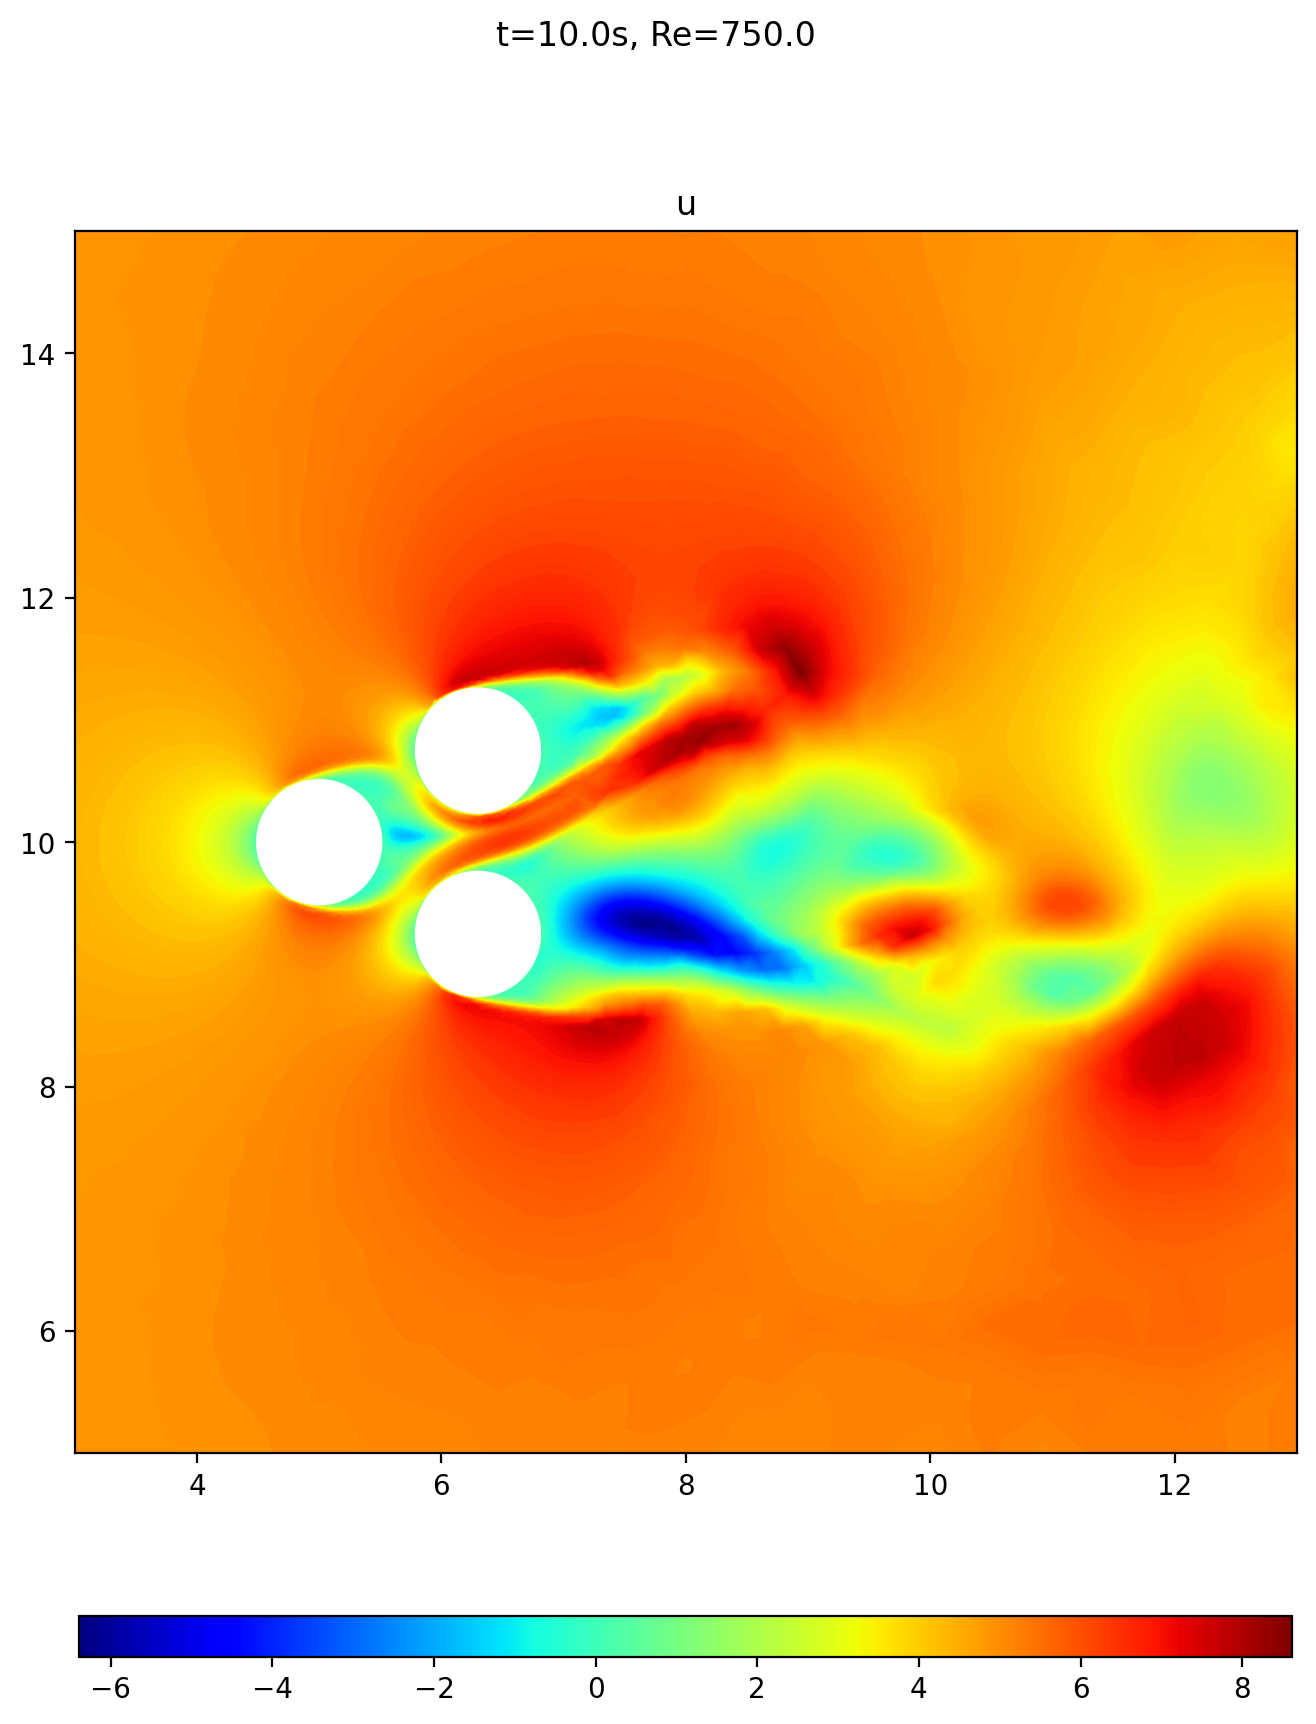

In [ ]:
%%px
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

if rank==0:
    fields_and_tiles = [
                (u_np, "u"),
                # (v_np, "v"),
                # (p_np, "p")
                ]
    sm_list = [sm_u, sm_v, sm_p]
    norm_list = [norm_u, norm_v, norm_p]

    fig, axs = plt.subplots(1, len(fields_and_tiles))
    # add_zoom(2.4)

    # add_zoom(2.4)

    if isinstance(axs, Axes):
        axs = [axs]

    # plt.gcf().set_figheight(plt.gcf().get_figheight() * 0.3)
    zoom = (len(axs) * 0.5 + 1)*1.7
    plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom * ((0.85)/len(axs) + 0.015 * len(axs)))
    plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom * 0.6)

    for i, (field, title) in enumerate(fields_and_tiles):
        cbar_i = fig.colorbar(sm_list[i], ax=axs[i], orientation='horizontal',
                              # pad = 0.08 + len(axs) * 0.025,
                              pad = 0.1,
                              aspect = 30, norm=norm_list[i],
                              shrink=0.8)
        axs[i].set_title(title)

    cyl_coords = [cyl1_coords, cyl2_coords, cyl3_coords]

    last_contours = []
    last_patches = []

    # 2) Funzione di inizializzazione (vuota, serve se usi blit=True)
    def init():
        for ax in axs:
            ax.clear()
            ax.set_aspect("equal")
        # ricrea le colorbar se necessario, oppure lasciale fisse come qui
        return []

    # 2) Funzione di inizializzazione (vuota, serve se usi blit=True)
    def update(frame):

        for cs in last_contours:
            cs.remove()
        last_contours.clear()

        # 2) Rimuovi le patch dei cilindri
        for patch in last_patches:
            patch.remove()
        last_patches.clear()

        conts = []
        for i, (field, _) in enumerate(fields_and_tiles):
            cont = axs[i].tricontourf(triang, field[frame, :], cmap="jet", levels=200
                                      # , norm=norm_list[i]
                                      )
            axs[i].set_aspect("equal")
            conts.append(cont)

        last_contours.extend(conts)

        for ax in axs:
            for cyl in cyl_coords:
                new_patches = ax.fill(cyl[:, 0], cyl[:, 1],
                                      facecolor='white',
                                      edgecolor='white',
                                      linewidth=1.5)
            # extend, not append
            last_patches.extend(new_patches)

        x_p, y_p = 0.4 * L, 0.5 * H # te per 30 gradi
        dist = 5

        for ax in axs:
            ax.set_xlim([x_p - dist, x_p + dist])
            ax.set_ylim([y_p - dist, y_p + dist])
        # plt.gca().set_xlim([x_p - dist, x_p + dist])
        # plt.gca().set_ylim([y_p - dist, y_p + dist])

        # fig.subplots_adjust(top=2.95, bottom=0)
        fig.suptitle(f"t={(frame*save_to_np_every_steps)/timesteps*T:.1f}s, Re={U_max * 2*R * rho_ / params[1][0]:.1f} ")

        return last_contours

    # Costruiamo l'animazione
    n_frames = ntimes
    ani = FuncAnimation(
        fig, update, frames=range(n_frames),
        blit=True, interval=100
    )

    ani.save("animazione.mp4", writer="ffmpeg", fps=10)

In [ ]:
%%px
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

if rank==0:
    fig, axs = plt.subplots(1, 3)
    # add_zoom(2.4)

    # add_zoom(2.4)

    plt.gcf().set_figheight(plt.gcf().get_figheight() * 0.3)
    zoom = 2.7
    plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom)
    plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom)

    # Aggiungi le colorbar statiche fuori dalla funzione di aggiornamento
    cbar_u = fig.colorbar(sm_u, ax=axs[0], orientation='horizontal', pad = 0.15, aspect = 30)
    axs[0].set_title("u")
    cbar_u = fig.colorbar(sm_v, ax=axs[1], orientation='horizontal', pad = 0.15, aspect = 30)
    axs[1].set_title("v")
    cbar_p = fig.colorbar(sm_p, ax=axs[2], orientation='horizontal', pad = 0.15, aspect = 30)
    axs[2].set_title("p")

    # 2) Funzione di inizializzazione (vuota, serve se usi blit=True)
    def init():
        for ax in axs:
            ax.clear()
            ax.set_aspect("equal")
        # ricrea le colorbar se necessario, oppure lasciale fisse come qui
        return []

    # Qui mettiamo i contenitori per gli artisti che cambiano
    last_contours = []
    last_patches = []

    def update(frame):
        # 1) Rimuovi i vecchi TriContourSet
        for cs in last_contours:
            cs.remove()
        last_contours.clear()

        # 2) Rimuovi le patch dei cilindri
        for patch in last_patches:
            patch.remove()
        last_patches.clear()

        # 3) Ridisegna i contour
        cs1 = axs[0].tricontourf(
            triang, u_np[frame, :],
            cmap="jet", levels=200, norm=norm_u
        )
        cs2 = axs[1].tricontourf(
            triang, v_np[frame, :],
            cmap="jet", levels=200, norm=norm_v
        )
        cs3 = axs[2].tricontourf(
            triang, p_np[frame, :],
            cmap="jet", levels=200, norm=norm_p
        )

        # memorizza i TriContourSet
        last_contours.extend([cs1, cs2])

        # 4) Ridisegna il cilindro, tenendo le patch appena creare in una lista
        for cyl in cyl_coords:
            patch = axs[0].fill(cyl[:,0], cyl[:,1], 'white', edgecolor='white', lw=1.5)[0]
            last_patches.append(patch)
            patch = axs[1].fill(cyl[:,0], cyl[:,1], 'white', edgecolor='white', lw=1.5)[0]
            last_patches.append(patch)

        # 5) Aggiorna il titolo
        t_val = frame / timesteps * T
        Re = U_max * np.cos(params[0][0]) * 2 * R * rho_ / params[1][0]
        fig.suptitle(f"t={t_val:.2f}s, Re={Re:.1f}")

        # Ritorniamo i due TriContourSet (basta loro, matplotlib sa rinfrescare i patch)
        return last_contours

    # Costruiamo l'animazione
    n_frames = ntimes
    ani = FuncAnimation(
        fig, update, frames=range(n_frames),
        blit=True, interval=100
    )

    # # Per vederla in Jupyter:
    # from IPython.display import HTML
    # HTML(ani.to_jshtml())

    # Oppure per salvarla:
    ani.save("animazione.mp4", writer="ffmpeg", fps=10)